In [83]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import random

import matplotlib.pyplot as plt
import numpy as np

from IPython import display

In [84]:
def get_dataset_slice_paths(image_dir):
  '''returns a list of paths to the image files'''
  image_file_list = os.listdir(image_dir)
  image_paths = [os.path.join(image_dir, fname) for fname in image_file_list]

  return image_paths

def map_image(image_filename):
  '''preprocesses the images'''
  img_raw = tf.io.read_file(image_filename)
  image = tf.image.decode_jpeg(img_raw)

  image = tf.cast(image, dtype=tf.float32)
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
  image = image / 255.0  
  image = tf.reshape(image, shape=(IMAGE_SIZE, IMAGE_SIZE, 3,))

  return image

In [85]:
paths = get_dataset_slice_paths(r"C:\Users\radha\DeepLearning\ImageDataSets")

In [86]:
len(paths)

10000

In [87]:
random.shuffle(paths)
paths

['C:\\Users\\radha\\DeepLearning\\ImageDataSets\\horse_1619.png',
 'C:\\Users\\radha\\DeepLearning\\ImageDataSets\\frog_1525.png',
 'C:\\Users\\radha\\DeepLearning\\ImageDataSets\\airplane_1664.png',
 'C:\\Users\\radha\\DeepLearning\\ImageDataSets\\automobile_1039.png',
 'C:\\Users\\radha\\DeepLearning\\ImageDataSets\\truck_1820.png',
 'C:\\Users\\radha\\DeepLearning\\ImageDataSets\\truck_1957.png',
 'C:\\Users\\radha\\DeepLearning\\ImageDataSets\\deer_1555.png',
 'C:\\Users\\radha\\DeepLearning\\ImageDataSets\\ship_1816.png',
 'C:\\Users\\radha\\DeepLearning\\ImageDataSets\\dog_1711.png',
 'C:\\Users\\radha\\DeepLearning\\ImageDataSets\\truck_1567.png',
 'C:\\Users\\radha\\DeepLearning\\ImageDataSets\\bird_1411.png',
 'C:\\Users\\radha\\DeepLearning\\ImageDataSets\\truck_1086.png',
 'C:\\Users\\radha\\DeepLearning\\ImageDataSets\\frog_1240.png',
 'C:\\Users\\radha\\DeepLearning\\ImageDataSets\\frog_1291.png',
 'C:\\Users\\radha\\DeepLearning\\ImageDataSets\\bird_1358.png',
 'C:\\Users

In [88]:
np.random.seed(42)
tf.random.set_seed(42)

In [89]:
# split the paths list into to training (80%) and validation sets(20%).
paths_len = len(paths)
train_paths_len = int(paths_len * 0.8)
train_paths = paths[:train_paths_len]
val_paths = paths[train_paths_len:]

In [90]:
val_paths

['C:\\Users\\radha\\DeepLearning\\ImageDataSets\\bird_1141.png',
 'C:\\Users\\radha\\DeepLearning\\ImageDataSets\\bird_1180.png',
 'C:\\Users\\radha\\DeepLearning\\ImageDataSets\\automobile_1459.png',
 'C:\\Users\\radha\\DeepLearning\\ImageDataSets\\deer_1607.png',
 'C:\\Users\\radha\\DeepLearning\\ImageDataSets\\automobile_1936.png',
 'C:\\Users\\radha\\DeepLearning\\ImageDataSets\\frog_1280.png',
 'C:\\Users\\radha\\DeepLearning\\ImageDataSets\\airplane_1515.png',
 'C:\\Users\\radha\\DeepLearning\\ImageDataSets\\truck_1991.png',
 'C:\\Users\\radha\\DeepLearning\\ImageDataSets\\dog_1524.png',
 'C:\\Users\\radha\\DeepLearning\\ImageDataSets\\deer_1393.png',
 'C:\\Users\\radha\\DeepLearning\\ImageDataSets\\dog_1482.png',
 'C:\\Users\\radha\\DeepLearning\\ImageDataSets\\horse_1917.png',
 'C:\\Users\\radha\\DeepLearning\\ImageDataSets\\deer_1975.png',
 'C:\\Users\\radha\\DeepLearning\\ImageDataSets\\horse_1906.png',
 'C:\\Users\\radha\\DeepLearning\\ImageDataSets\\horse_1808.png',
 'C:\\U

In [108]:
BATCH_SIZE=100
LATENT_DIM=256
IMAGE_SIZE=32

In [109]:
# load the training image paths into tensors, create batches and shuffle
training_dataset = tf.data.Dataset.from_tensor_slices((train_paths))
training_dataset = training_dataset.map(map_image)
training_dataset = training_dataset.shuffle(1000).batch(BATCH_SIZE)

validation_dataset = tf.data.Dataset.from_tensor_slices((val_paths))
validation_dataset = validation_dataset.map(map_image)
validation_dataset = validation_dataset.batch(BATCH_SIZE)

In [110]:
print(f'number of batches in the training set: {len(training_dataset)}')
print(f'number of batches in the validation set: {len(validation_dataset)}')

number of batches in the training set: 80
number of batches in the validation set: 20


In [111]:
class Sampling(tf.keras.layers.Layer):
  def call(self, inputs):
    """Generates a random sample and combines with the encoder output
    
    Args:
      inputs -- output tensor from the encoder

    Returns:
      `inputs` tensors combined with a random sample
    """
    ### START CODE HERE ###
    mu, sigma = inputs
    batch = tf.shape(mu)[0]
    dim = tf.shape(mu)[1]
    epsilon = tf.keras.backend.random_normal(shape = (batch, dim))
    z = mu + tf.exp(0.5 * sigma) * epsilon
    ### END CODE HERE ###
    return  z

In [112]:
def encoder_layers(inputs, latent_dim):
  """Defines the encoder's layers.
  Args:
    inputs -- batch from the dataset
    latent_dim -- dimensionality of the latent space

  Returns:
    mu -- learned mean
    sigma -- learned standard deviation
    batch_3.shape -- shape of the features before flattening
  """
  ### START CODE HERE ###
  x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), strides = 2, 
                             activation = 'relu', padding = 'same', 
                             name = 'enc_conv1')(inputs)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), strides = 2, 
                             activation = 'relu', padding = 'same', 
                             name = 'enc_conv2')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), strides = 2, 
                             activation = 'relu', padding = 'same', 
                             name = 'enc_conv3')(x)
  batch_3 = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Flatten(name = 'enc_flatten')(batch_3)

  x = tf.keras.layers.Dense(1024, activation = 'relu', name = 'enc_dense')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  mu = tf.keras.layers.Dense(LATENT_DIM, name = 'latent_mu')(x)
  sigma = tf.keras.layers.Dense(LATENT_DIM, name = 'latent_sigma')(x)  
  ### END CODE HERE ###

  # revise `batch_3.shape` here if you opted not to use 3 Conv2D layers
  return mu, sigma, batch_3.shape

In [113]:
def encoder_model(latent_dim, input_shape):
  """Defines the encoder model with the Sampling layer
  Args:
    latent_dim -- dimensionality of the latent space
    input_shape -- shape of the dataset batch

  Returns:
    model -- the encoder model
    conv_shape -- shape of the features before flattening
  """
  ### START CODE HERE ###
  inputs = tf.keras.layers.Input(shape = input_shape)
  mu, sigma, conv_shape = encoder_layers(inputs, latent_dim = LATENT_DIM)
  z = Sampling()((mu, sigma))
  model = tf.keras.Model(inputs, outputs = [mu, sigma, z])
  ### END CODE HERE ###
  model.summary()
  return model, conv_shape

In [114]:
def decoder_layers(inputs, conv_shape):
  """Defines the decoder layers.
  Args:
    inputs -- output of the encoder 
    conv_shape -- shape of the features before flattening

  Returns:
    tensor containing the decoded output
  """
  ### START CODE HERE ###
  units = conv_shape[1] * conv_shape[2] * conv_shape[3]
  x = tf.keras.layers.Dense(units, activation = 'relu', name = 'dec_dense')(inputs)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]),
                              name = 'dec_reshape')(x)
  
  x = tf.keras.layers.Conv2DTranspose(filters = 128, kernel_size = (3, 3), 
                                      strides = 2, activation = 'relu', 
                                      padding = 'same', name = 'dec_deconv1')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size = (3, 3), 
                                      strides = 2, activation = 'relu', 
                                      padding = 'same', name = 'dec_deconv2')(x)
  x = tf.keras.layers.BatchNormalization()(x)      

  x = tf.keras.layers.Conv2DTranspose(filters = 32, kernel_size = (3, 3), 
                                      strides = 2, activation = 'relu', 
                                      padding = 'same', name = 'dec_deconv3')(x)
  x = tf.keras.layers.BatchNormalization()(x)        

  x = tf.keras.layers.Conv2DTranspose(filters = 3, kernel_size = (3, 3), 
                                      strides = 1, activation = 'sigmoid', 
                                      padding = 'same', name = 'dec_deconv4')(x)
  ### END CODE HERE ###
  return x

In [115]:
def decoder_model(latent_dim, conv_shape):
  """Defines the decoder model.
  Args:
    latent_dim -- dimensionality of the latent space
    conv_shape -- shape of the features before flattening

  Returns:
    model -- the decoder model
  """
  ### START CODE HERE ###
  inputs = tf.keras.layers.Input(shape = (latent_dim, ))
  outputs = decoder_layers(inputs, conv_shape)
  model = tf.keras.Model(inputs, outputs)
  ### END CODE HERE ###
  model.summary()
  return model

In [116]:
def kl_reconstruction_loss(inputs, outputs, mu, sigma):
  """ Computes the Kullback-Leibler Divergence (KLD)
  Args:
    inputs -- batch from the dataset
    outputs -- output of the Sampling layer
    mu -- mean
    sigma -- standard deviation

  Returns:
    KLD loss
  """
  kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
  return tf.reduce_mean(kl_loss) * -0.5

In [117]:
def vae_model(encoder, decoder, input_shape):
  """Defines the VAE model
  Args:
    encoder -- the encoder model
    decoder -- the decoder model
    input_shape -- shape of the dataset batch

  Returns:
    the complete VAE model
  """
  ### START CODE HERE ###
  inputs = tf.keras.layers.Input(shape = input_shape)
  mu, sigma, z = encoder(inputs)
  reconstructed = decoder(z)

  model = tf.keras.Model(inputs, reconstructed)

  loss = kl_reconstruction_loss(inputs, z, mu, sigma)
  model.add_loss(loss)
  ### END CODE HERE ###
  return model

In [118]:
def get_models(input_shape, latent_dim):
  """Returns the encoder, decoder, and vae models"""
  ### START CODE HERE ###
  encoder, conv_shape = encoder_model(latent_dim = latent_dim, input_shape = input_shape)
  decoder = decoder_model(latent_dim = latent_dim, conv_shape = conv_shape)
  vae = vae_model(encoder, decoder, input_shape = input_shape)
  ### END CODE HERE ###
  return encoder, decoder, vae

In [119]:
encoder, decoder, vae = get_models(input_shape=(32,32,3,), latent_dim=LATENT_DIM)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 enc_conv1 (Conv2D)             (None, 16, 16, 32)   896         ['input_7[0][0]']                
                                                                                                  
 batch_normalization_16 (BatchN  (None, 16, 16, 32)  128         ['enc_conv1[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 enc_conv2 (Conv2D)             (None, 8, 8, 64)     18496       ['batch_normalization_16[0]

In [120]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_metric = tf.keras.metrics.Mean()
mse_loss = tf.keras.losses.MeanSquaredError()
bce_loss = tf.keras.losses.BinaryCrossentropy()

In [121]:
def generate_and_save_images(model, epoch, step, test_input):
  """Helper function to plot our 16 images

  Args:

  model -- the decoder model
  epoch -- current epoch number during training
  step -- current step number during training
  test_input -- random tensor with shape (16, LATENT_DIM)
  """
  predictions = model.predict(test_input)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      img = predictions[i, :, :, :] * 255
      img = img.astype('int32')
      plt.imshow(img)
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  fig.suptitle("epoch: {}, step: {}".format(epoch, step))
  plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
  plt.show()

In [122]:
def display_one_row(disp_images, offset, shape=(28, 28)):
  '''Displays a row of images.'''
  for idx, image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    image = np.reshape(image, shape)
    plt.imshow(image)


def display_results(disp_input_images, disp_predicted):
  '''Displays input and predicted images.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(IMAGE_SIZE,IMAGE_SIZE,3))
  display_one_row(disp_predicted, 20, shape=(IMAGE_SIZE,IMAGE_SIZE,3))

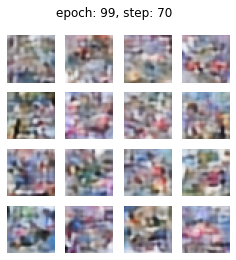

Epoch: 99 step: 70 mean loss = 21.956617
Epoch: 99 step: 71 mean loss = 21.955473
Epoch: 99 step: 72 mean loss = 21.954191
Epoch: 99 step: 73 mean loss = 21.952957
Epoch: 99 step: 74 mean loss = 21.951733
Epoch: 99 step: 75 mean loss = 21.950523
Epoch: 99 step: 76 mean loss = 21.949274
Epoch: 99 step: 77 mean loss = 21.948097
Epoch: 99 step: 78 mean loss = 21.946762
Epoch: 99 step: 79 mean loss = 21.945574


In [123]:
# Training loop. Display generated images each epoch

### START CODE HERE ###
epochs = 100
### END CODE HERE ###

random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])
generate_and_save_images(decoder, 0, 0, random_vector_for_generation)

for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))

  # Iterate over the batches of the dataset.
  for step, x_batch_train in enumerate(training_dataset):
    with tf.GradientTape() as tape:
      ### START CODE HERE ### 
      reconstructed = vae(x_batch_train)
      # Compute reconstruction loss
      flattened_inputs = tf.reshape(x_batch_train, shape = [-1])
      flattened_outputs = tf.reshape(reconstructed, shape = [-1])
      loss = mse_loss(flattened_inputs, flattened_outputs) * 32 * 32 * 3
      loss += sum(vae.losses)
    grads = tape.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))
    ### END CODE HERE
    
    loss_metric(loss)

    if step % 10 == 0:
      display.clear_output(wait=False)    
      generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
    print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))

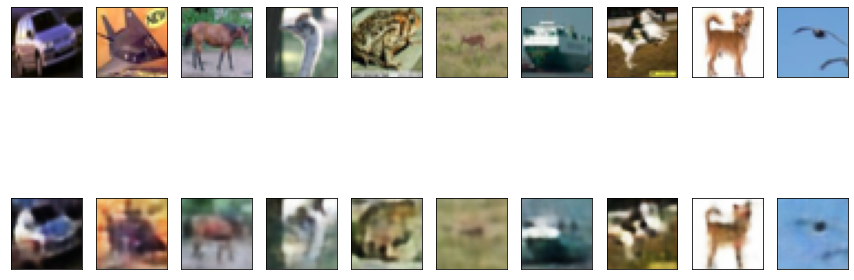

In [142]:
test_dataset = validation_dataset.take(1)
output_samples = []

for input_image in tfds.as_numpy(test_dataset):
      output_samples = input_image

idxs = np.random.choice(64, size=10)

vae_predicted = vae.predict(test_dataset)
display_results(output_samples[idxs], vae_predicted[idxs])

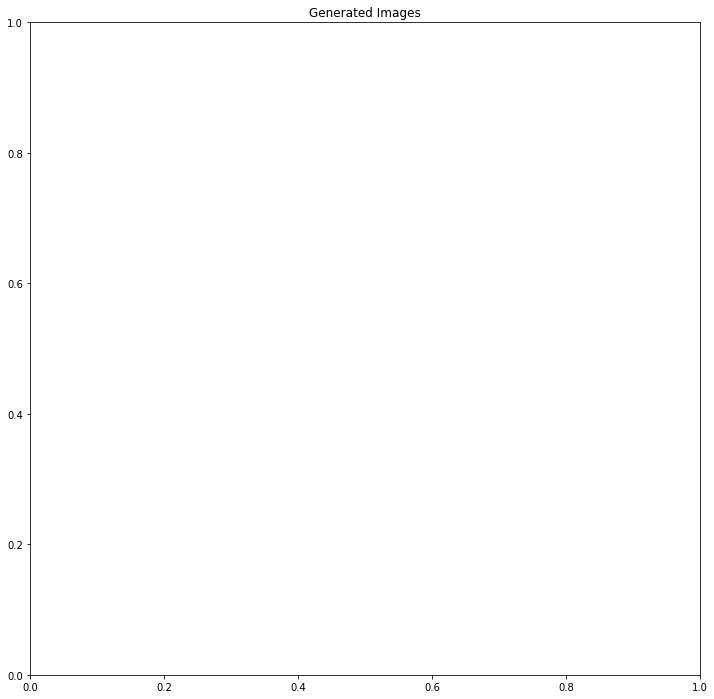

In [141]:
def plot_images(rows, cols, images, title):
    '''Displays images in a grid.'''
    grid = np.zeros(shape=(rows*32, cols*32, 3))
    for row in range(rows):
        for col in range(cols):
            grid[row*32:(row+1)*32, col*32:(col+1)*32, :] = images[row*cols + col]

    plt.figure(figsize=(12,12))
    plt.title(title)
    plt.imsave("Generated_images_set8.jpg", grid)

# initialize random inputs
test_vector_for_generation = tf.random.normal(shape=[25, LATENT_DIM])

# get predictions from the decoder model
predictions= decoder.predict(test_vector_for_generation)

# plot the predictions
plot_images(5,5,predictions,'Generated Images')